In [153]:
import pandas as pd
from konlpy.tag import Okt
from konlpy.tag import Mecab
import re

import matplotlib
import matplotlib.font_manager as fm
font_location = 'C:/Windows/Fonts/malgunbd.ttf' # matplotlib 한글 맑은 고딕 폰트 설정
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import requests
from bs4 import BeautifulSoup
import json
import time

okt = Okt()
mecab = Mecab()

In [208]:
#키워드 리뷰 불러오기
def topic_review(topic):
    reviews = []
    for review in review_list:
        if topic in review:
            reviews.append(review)
    return reviews

#LDA & DTM
def get_dtm(document, ngram_min=1, ngram_max=3, n_topics=10, n_words=20):
    tf_vect = CountVectorizer(ngram_range = (ngram_min,ngram_max), max_df = 0.8, min_df = 2)
    dtm = tf_vect.fit_transform(document)

    n_topics= n_topics
    lda = LatentDirichletAllocation(n_components = n_topics, topic_word_prior=0.01, doc_topic_prior=0.01)
    lda.fit(dtm)

    names = tf_vect.get_feature_names()
    topics = dict()
    n_words = n_words

    for idx, topic in enumerate(lda.components_):
        vocab = []
        for i in  topic.argsort()[:-(n_words-1):-1]:
            vocab.append((names[i], topic[i].round(2)))
        topics[idx+1] = [(names[i], topic[i].round(2)) for i in  topic.argsort()[:-(n_words-1):-1]]

    dtm_matrix = lda.transform(dtm)    
    return tf_vect, lda, dtm, topics, dtm_matrix

#주제당 가장 큰 비중을 차지하는 리뷰 출력
def get_RepReview(lda, dtm, topics):
    max_dict = dict()
    for idx, vec in enumerate(lda.transform(dtm)):
        t = vec.argmax()
        if(t not in max_dict):
            max_dict[t] = (vec[t], idx)
        else:
            if(max_dict[t][0] < vec[t]):
                max_dict[t] = (vec[t], idx)

    sorted_review = sorted(max_dict.items(), key = lambda x: x[0], reverse=False)

    for key, value in sorted_review:
        print('주제 {}: {}'.format(key+1, topics[key+1]))
        print('[주제 {}의 대표 리뷰 :{}]\n{}\n\n'.format(key+1, value[0], review_list[value[1]]))

In [170]:
review_list = []
pages = 100
for page in range(pages):
    try:
        url = 'https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json?ticket=auto1&templateId=&pool=cbox&_callback=jQuery1707609017391243922_1608381365685&lang=ko&country=&objectId=137863&categoryId=&pageSize=10&indexSize=10&groupId=&listType=OBJECT&pageType=default&page={}&refresh=false&sort=NEW&_=1608382297292'.format(page)
        params = {'ticket': 'auto1',
        # templateId: 
        'pool': 'cbox',
        '_callback': 'jQuery1707609017391243922_1608381365682',
        'lang': 'ko',
        # country: 
        'objectId': '137863',
        # 'categoryId': 
        'pageSize': 10,
        'indexSize': 10,
        # 'groupId': 
        'listType': 'OBJECT',
        'pageType': 'default',
        'page': page,
        'refresh': 'false',
        'sort': 'NEW',
        '_': 1608381559312}
        headers = {'referer': 'https://auto.naver.com/car/talk.nhn?yearsId=137863',
                  'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'}
        time.sleep(5)
        resp = requests.get(url, data= params, headers = headers)
        soup = BeautifulSoup(resp.content, 'lxml')

        data = resp.text[resp.text.index('(') + 1 : resp.text.rindex(')')]
        temp_parser = json.loads(data)

        review_per_page = 10
        for i in range(review_per_page):
            contents = temp_parser['result']['commentList'][i]['contents']
            review_list.append(contents)
    except:
        print(page)

70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [149]:
from konlpy.tag import Mecab

mecab = Mecab()

In [167]:
review_list = set(review_list)

# 명사 + @

In [163]:
review_token = []
for review in review_list:
    review = re.sub('([a-zA-Z])','',review)
    review = re.sub('[ㄱ-ㅎㅏ-ㅣ]+','',review)
    review = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…;》\n]','',review)
    temp_token = []
    for word, pos in mecab.pos(review):
        if pos in ['NNG', 'NNP', 'VV', 'VA', 'VX', 'VCP', 'VCN', 'MAG']:
            temp_token.append(word)
    review_token.append((' ').join(temp_token))

C:\Users\sb\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


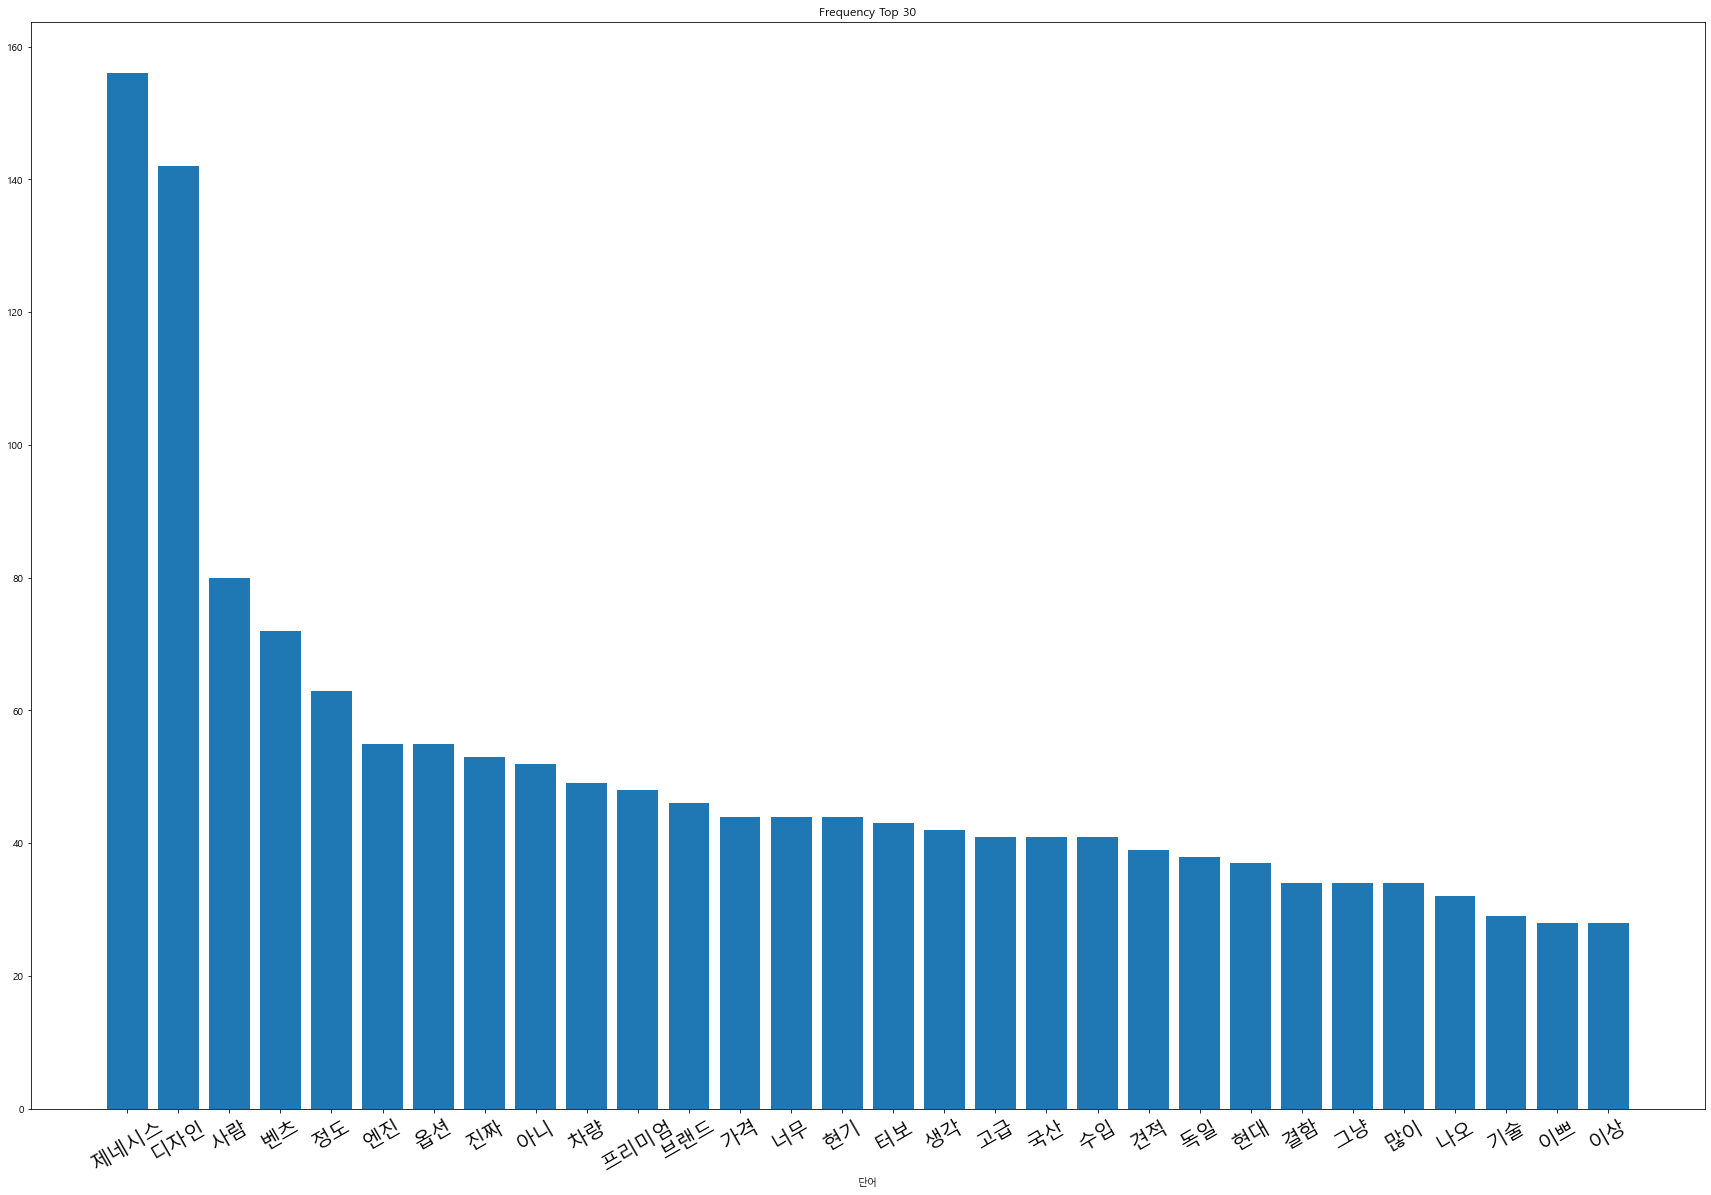

In [164]:
tf_vect = CountVectorizer(max_df = 0.85, max_features=10000, ngram_range=(1,3))
dtm = tf_vect.fit_transform(review_token)

vocab = dict()
for idx, word in enumerate(tf_vect.get_feature_names()):
    vocab[word] = dtm.getcol(idx).sum()
words = sorted(vocab.items(), key = lambda x: x[1], reverse = True)

max = 30
plt.figure(figsize=(30,20))
plt.bar(range(max), [i[1] for i in words[:max]])
plt.title('Frequency Top 30')
plt.xlabel('단어')
ax = plt.subplot()
ax.set_xticks(range(max))
ax.set_xticklabels([i[0] for i in words[:max]], rotation=30, size=20)
plt.show()

# 명사토큰

In [ ]:
review_nouns = []
for review in review_list:
    review = re.sub('([a-zA-Z])','',review)
    review = re.sub('[ㄱ-ㅎㅏ-ㅣ]+','',review)
    review = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…;》\n]','',review)
    temp_token = []
    for word in mecab.nouns(review):
        temp_token.append(word)
    review_nouns.append((' ').join(temp_token))

C:\Users\sb\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


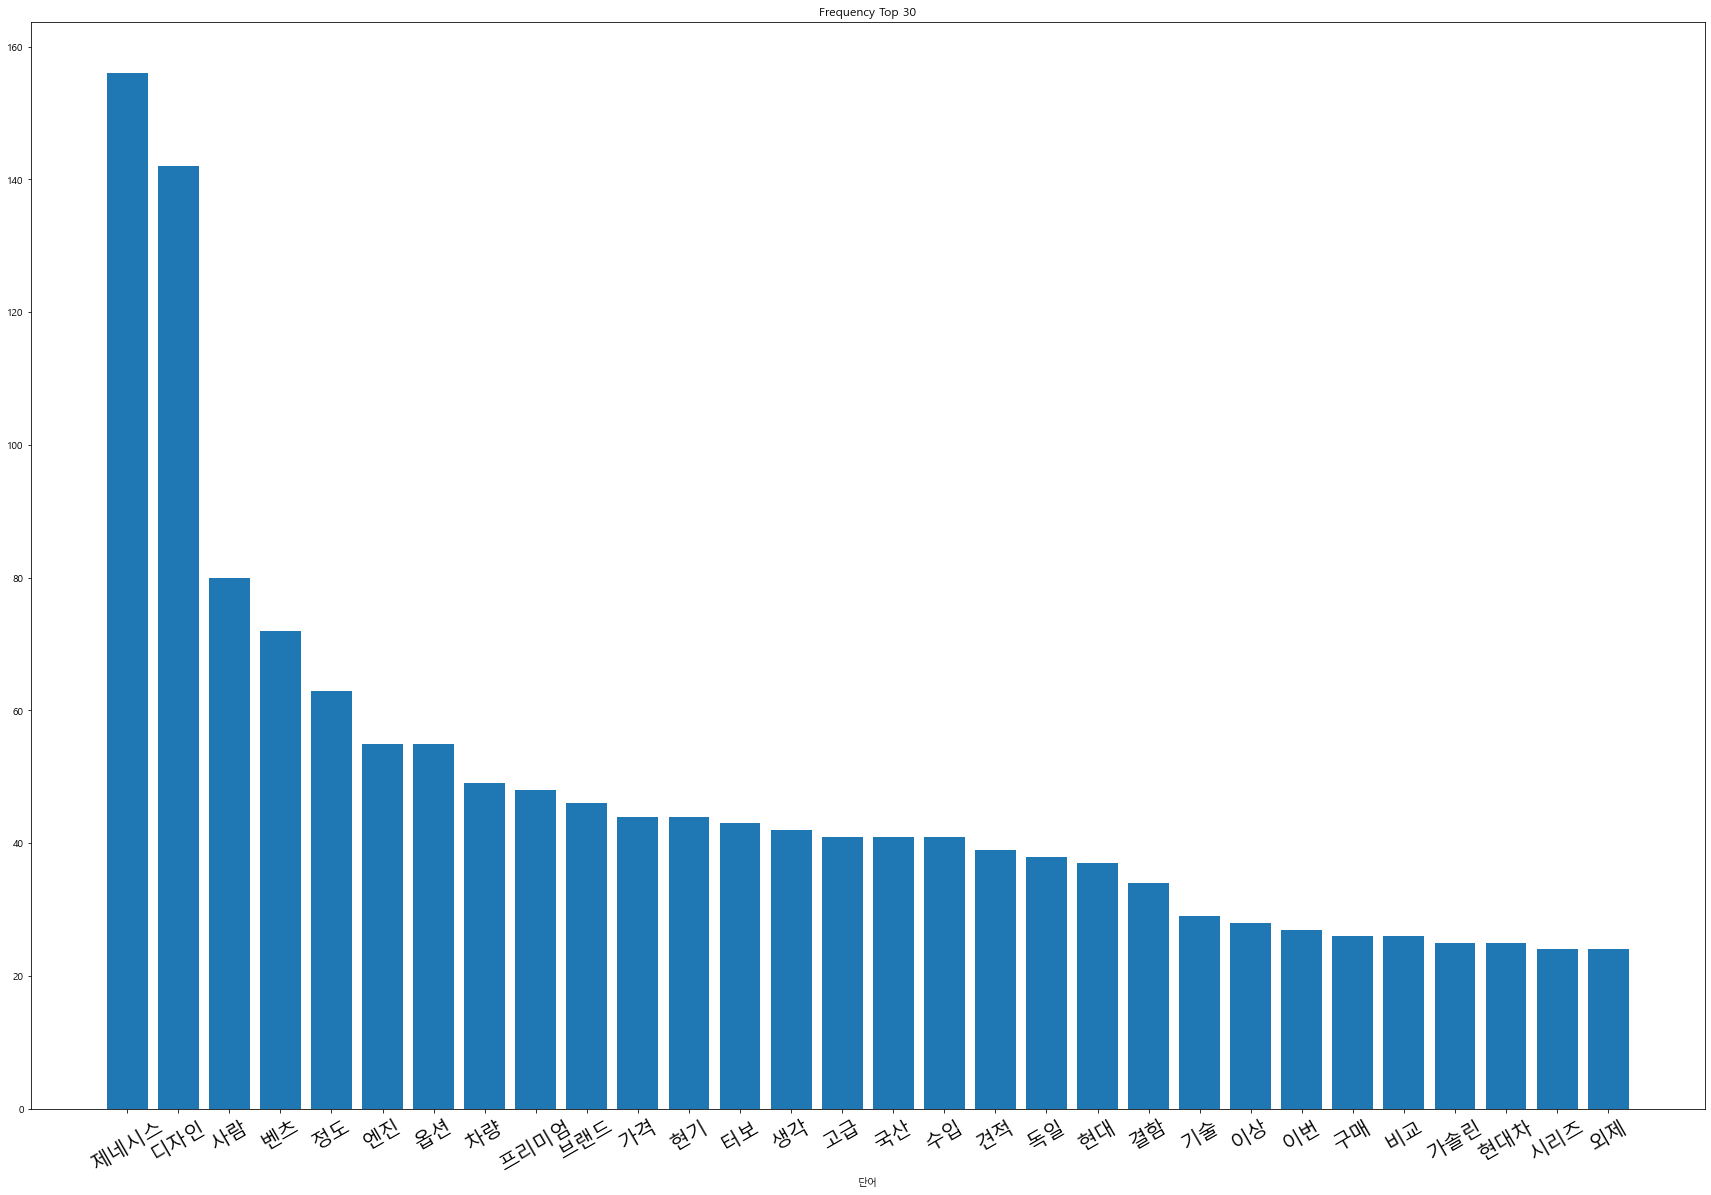

In [183]:
tf_vect = CountVectorizer(max_df = 0.85, max_features=10000, ngram_range=(1,3))
dtm = tf_vect.fit_transform(review_nouns)

vocab = dict()
for idx, word in enumerate(tf_vect.get_feature_names()):
    vocab[word] = dtm.getcol(idx).sum()
words = sorted(vocab.items(), key = lambda x: x[1], reverse = True)

max = 30
plt.figure(figsize=(30,20))
plt.bar(range(max), [i[1] for i in words[:max]])
plt.title('Frequency Top Nouns 30')
plt.xlabel('단어')
ax = plt.subplot()
ax.set_xticks(range(max))
ax.set_xticklabels([i[0] for i in words[:max]], rotation=30, size=20)
plt.show()

In [191]:
topic_review('벤츠')

['차가 고장도 안나고 18년이 지났는데 벤츠S도 타봤는데 특별히 내차를 욕할 이유가 없다라고 느낌 18년전에 2,300만원 주고 산 차를 아직도 탄다는 거에 감사하고 있습니다. 그당시는 제네시스 부럽지 않았던 차',
 '벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술',
 '12f2sd님\nBEST풀옵으로 이정도 차살정도 능력되는사람은 bmw를타든 벤츠를 타든 다탄다 비엠보다뭐가 어쩌고 벤츠보다 뭐 어쩌고 할사람들은 애초에 이차를 구매할 능력이 안된다는것이 팩트\n\nWilliam Kim님\n독일차 매니아들이 우르르 몰려와 악평을 남기는데 혈안이 되어있네요. 신형 G80이 그저 무시할 만한 모델이 아니라는 것에 대한 반증으로 보입니다.',
 '벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ',
 '결국은 현기일뿐..제네시스 풀옵이 얼마정도하지? 1억은 되려나?\n뭐 1억 좀 넘는다 가정해도..그 돈으로 벤츠나 비엠 깡통 사겠네..벤츠나 비엠도 등급이 나뉘는데 낮은 등급 차량들하고 현기 최고등급이랑 

In [206]:
tf_vect, lda, dtm, topics, dtm_matrix = get_dtm(review_token)

In [209]:
get_RepReview(lda, dtm, topics)

주제 1: [('제네시스', 32.43), ('브랜드', 22.93), ('사람', 20.05), ('버전', 18.12), ('디자인', 17.15), ('너무', 16.0), ('수입', 14.06), ('세로', 14.01), ('프리미엄', 13.84), ('벤틀리', 12.46), ('옵션', 12.07), ('가격', 11.96), ('정신', 10.5), ('정도', 10.35), ('현기', 10.08), ('오너', 10.01), ('가로 버전', 10.01), ('세로 버전', 10.01)]
[주제 1의 대표 리뷰 :0.9992688870836715]
G80 2.5 awd 풀옵 타는 오너입니다. 진심 독일차 실필요없습니다. 전차가 벤츠 마이바흐 , 벤틀리 였는데 주행감이야 비좁은 한국땅에 눈감고 타면 다 고만고만하고 G80 편의옵션, 안전옵션은 넘사벽으로 더 좋습니다. 정비 예약도 쉽고 부품수급도 바로바로 되서 아주 편리하구요. 블루링크 한번 맛보면 수입차 못타요 . 게다가 제네시스 올해의 차로 뽑혔던 전적도 있고 IIHS충돌실험 다 우수 평가 받았으니 안전 걱정은 안하셔도 되요~~  요즘 경기신축아파트도 10억이상 시대에 누가 미련하게 고작 이동수단으로 하차감따위 과시하나요 ? 진정한 부자는 제네시스 탑니다.  제네시스 사고 애국하세요


주제 2: [('디자인', 42.56), ('사람', 39.22), ('벤츠', 38.25), ('정도', 34.05), ('제네시스', 26.94), ('비엠', 22.12), ('나라', 21.57), ('수입', 19.48), ('현기', 17.44), ('이번', 16.11), ('한국', 14.55), ('우리', 13.93), ('벤츠 비엠', 13.11), ('국내', 12.01), ('현대차', 12.01), ('차량', 11.99), ('브랜드', 11.77), ('댓글', 10.62)]
[주제 2의 대표 리뷰 :0.9994378513429106]
결국은 현기일뿐..제네시스 풀옵이 얼마정도

In [ ]:
import pyLDAvis.sklearn

visual = pyLDAvis.sklearn.prepare(lda_model=lda, dtm=dtm, vectorizer=tf_vect)
pyLDAvis.display(visual)